# Warhammer calculations

In [1]:
from __future__ import absolute_import, division, print_function
from builtins import *
import scipy.stats as stats
import scipy.misc as scm
import matplotlib.pyplot as plt
import os
%matplotlib inline

## Function defines

In [2]:
def successes(tries, prob):
    return {x: round(stats.binom.pmf(x, tries, prob) * 1000) / 1000 for x in range(tries+1)}

In [3]:
def compound_successes(profile, prob):
    return {x: round(sum(stats.binom.pmf(x, y, prob) * profile[y] for y in profile if y >= x) * 1000) / 1000 for x in profile}

In [4]:
def chances_from_dice(target, n, faces):
    if faces == 1: return 1
    return (1 / faces ** n) * sum(((-1) ** i) * scm.comb(n, i) * scm.comb(target - faces * i - 1, n - 1) 
                                  for i in range(int((target - n) / faces) + 1))

# Using a major result of polynomial algebra in combinatorics, find the coefficient of x^target in (1 + x + ... + x^6)^n

In [5]:
def get_damage(profile, damage_list, target):
    n = len(damage_list)
    output = {0: profile[0]} 
    for hits in profile:
        if hits == 0 or profile[hits] < 0.005: continue
        for d in range(hits * min(damage_list), max(damage_list) * hits + 1, min(damage_list)):
            capped = min(target['model'] * hits, target['total'], d)
            if capped in output:
                output[capped] += profile[hits] * chances_from_dice(d, hits, n)
            else:
                output[capped] = profile[hits] * chances_from_dice(d, hits, n)
    return output    

In [6]:
def wound_chart(profiles, target):
    profile_damage = damage_dealt(profiles[0], target)
    fig = plt.figure()
    plt.title('{shots} shots with {damage} damage ({p_hit:.2f} to hit, {p_wound:.2f} to wound)'.format(**profiles[0]))
    plt.ylabel('Probability, %')
    plt.xlabel('Wounds lost')
    plt.bar(profile_damage.keys(), [i * 100 for i in profile_damage.values()], color='g', width=1, align='center')
    fig.text(0.95, 0.54, 'Expected: {:.1f} wounds'.format(sum(key * value for key, value in profile_damage.items())),
             fontsize=12, fontweight='bold', horizontalalignment='left')
    fig.text(0.95, 0.8, 'Target profile',
             fontsize=12, fontweight='bold', horizontalalignment='left')
    fig.text(0.95, 0.76, 'Model wounds: {model}\nUnit wounds: {total}\nSave: {save:.2f}'.format(**target),
             fontsize=12, verticalalignment='top')

In [7]:
def damage_dealt(profile, target):
    damage_list = damage_types[profile['damage']]
    hits = successes(profile['shots'], profile['p_hit'])
    wounds = compound_successes(hits, profile['p_wound'])
    unsaved = compound_successes(wounds, 1 - target['save'])
    return get_damage(unsaved, damage_list, target)

In [8]:
damage_types = {'1': [1], '2': [2], '3': [3], 'd3': [1, 2, 3], 'd6': [1, 2, 3, 4, 5, 6]}
profiles = []

## Variable input

In [9]:
profiles.append({'shots': 10, 'p_hit': 4 / 6, 'p_wound': 4 / 6, 'damage': '1'})
target = {'model': 1, 'total': 10, 'save': 2 / 6}

## Work

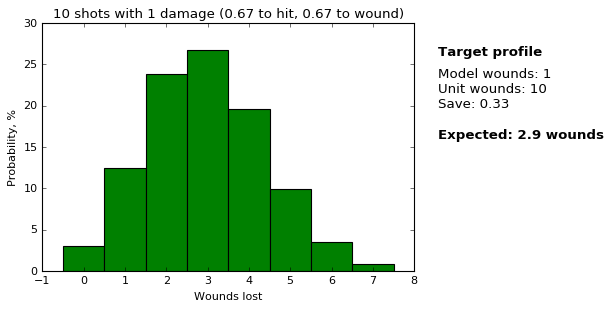

In [10]:
wound_chart(profiles, target)

## Mathhammer for 8th edition
### The problem of averages

A common way to figure odds in Warhammer is by using the expectation aka 'average outcome' of the binomial series: just multiply the number of rolls by the probability of success, and get expected damage. 10 shots, 1/2 to hit, 1/2 to wound, 1/3 saved, 1 damage gives 5 / 3 wounds, the 1.7 that we have seen reported above. Easy, so why bother with charts?

There are several problems with naive expectation calculation. The first is that the expectation can be misleading, as we have already seen, and any case it does not easily translate into a probability. I expect to deal 8 wounds, so what? Does that mean that I have at least even odds of killing a model with 8 wounds? Not necessarily, you may have better than even odds, or worse, the expectation itself tells you little.

The second, an even more significant problem, is that the binomial expectation formula simply stops working when it runs up against wound limits, either at the model level, or at the unit level. When you apply it, you think you are calculating over average outcomes, but you aren't, or rather the outcomes are fictional and not related to what actually occurs in-game. In-game, you cannot calculate the expectation at all unless you know the target wound profile, attackers' statline by itself is not enough, the expectation changes depending on what you are firing at. Players, of course, know this at an intuitive level — it's why you don't fire high damage weapons into hordes, and why you would be reticent to fire a lascannon shot to remove that one last wound on a vehicle. The distribution is truncated by a hard cap on maximum damage, which makes the binomial formula inapplicable. The distribution is similarly truncated at the other tail by the presence of 0 — negative hits are not a thing.

Let's demonstrate this vivdly for a case of 4 Kataphron Breachers firing S6 d6 damage Heavy Arc Rifles, with re-rolls, at a T5, 6 wound Venom:

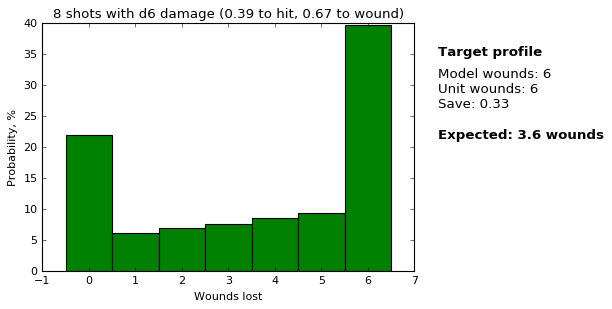

In [11]:
profiles[0] = {'shots': 8, 'p_hit': 1 / 3 + 1 / 6 * 1 / 3, 'p_wound': 2 / 3, 'damage': 'd6'}
target = {'model': 6, 'total': 6, 'save': 1 / 3}
wound_chart(profiles, target)

That is certainly not a binomial distribution. 

The plot reports an expecation, which is calculated from the actual distribution. Compare it with the naive calculation: 8 shots, 0.39 to hit, 0.67 to wound, 0.67 unsaved, d6 damage, take 3.5 expectation, giving:

In [12]:
8 * 7 / 18 * 2 / 3 * 2 / 3 * 3.5

4.839506172839506

1.2 expected wounds more. This overestimation is always going to be the case with high damage weapons and the naive calculation, because it incorporates outcomes such as all sixes rolled on all successful hits. In reality, your damage is capped at 6, and the potential for multiple high rolls on damage shouldn't raise the expected wounds, but there is no easy way to incorporate that cap into the naive calculation.

You can see a similar problem at the other tail — as wounds can't go below 0, the distribution is also truncated on that end, again something that will always happen for low odds attacks.

The plot has another advantage over the expectation, it actually gives a probability, something that neither the true average, nor the naive estimate provide. Here we can see that our Kataphrons have an almost 40% chance of deleting the Venom in one volley. Let's add another breacher into the mix: 

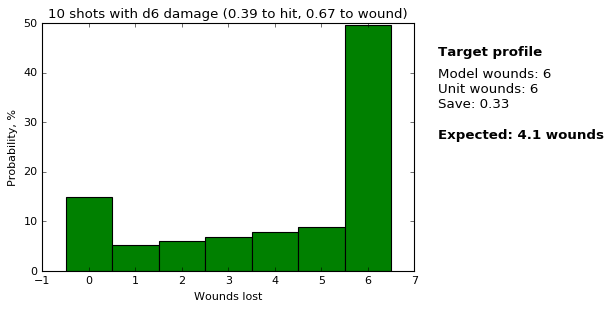

In [13]:
profiles[0]['shots'] = 10
wound_chart(profiles, target)

The expectation has grown by 0.5, but the chance of a kill increased by 10 percentage points, now it's a coin toss. Unfortunately, the Venom still has pretty good odds of escaping unscathed. Such is the power of **Flickerfield** and invulnerable save. 5 Kataphrons is 175 points, and clearly we are not getting efficiency here. Let's consider a unit that can actually hit, 3 Ironstriders (BS 3+) at 150 points with twin Autocannons (Heavy 4, S6, 2 damage), _without canticle_:

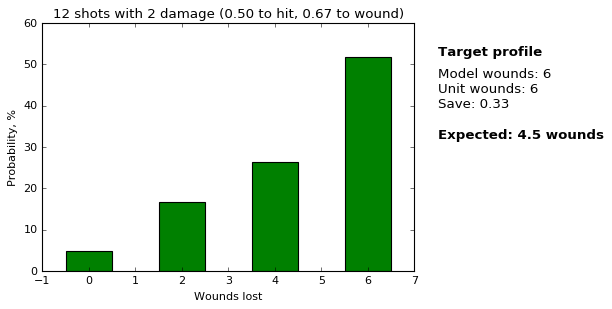

In [14]:
profiles[0] = {'shots': 12, 'p_hit': 1 / 2, 'p_wound': 2 / 3, 'damage': '2'}
wound_chart(profiles, target)

A completely different picture! The chance to kill outright is not that much higher, albeit it's now over 50%. The biggest difference is in the chance of making no progress at all, which went from ~15% to ~5%. What is driving this? It's the fact that the distribution of 12 shots with fixed damage is much 'narrower' than of 10 with d6 damage, there is less variance, which specifically means there is less of a tail to the left of 0, which in the Kataphron case is substantial.

Add in canticle for re-rolls of 1s:

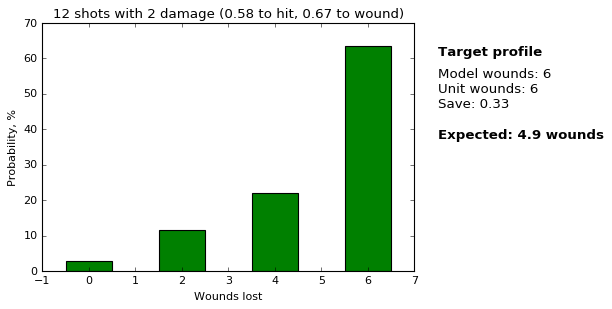

In [24]:
profiles[0]['p_hit'] = 1 / 2 + 1 / 6 * 1 / 2
wound_chart(profiles, target)

If that Venom isn't dead, it will be on its last wound. In the next section we will pick up on the value of narrow distributions and the strength of compounding. Preparatory teaser: for the same range and number of attacks, which would you pick: an S1 (6+ to wound) flamer, which auto-hits and deals mortal wounds or an S5 heavy bolter fired at BS 3+ and facing a 5+ save? The naive expectation is the same!